In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import os,cmocean
import scipy.io as sio
from scipy import interpolate
from pyproj import Proj
from bathy_helpers import *
from bathy_readers import *
from matplotlib import path

In [2]:
# Load bathy, and the t and f grid
mfile = sio.loadmat('/home/mdunphy/NEMO_PREPARATION/1_Seagrid_generator/cascdem/hhh.mat')
bathyjpi = mfile['h_wet2']  # JP's nearest interpolation (before removing lakes,etc)
bathyjpi[np.isnan(bathyjpi)]=0

bathyjp = getnemo('/ocean/dlatorne/MEOPAR/NEMO/WC3_PREP/2_bathy/bathy_meter_min4.nc', fillmissing=True)
bathyd1 = getnemo('/home/mdunphy/MEOPAR/NEMO-forcing/grid/bathy_downonegrid2.nc',     fillmissing=True)
bathy6  = getnemo('/home/mdunphy/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea6.nc', fillmissing=True)

cnc = nc.Dataset('/home/mdunphy/MEOPAR/NEMO-forcing/grid/coordinates_seagrid_SalishSea.nc', 'r')
glamf = cnc.variables['glamf'][0,...]; gphif = cnc.variables['gphif'][0,...]
glamt = cnc.variables['glamt'][0,...]; gphit = cnc.variables['gphit'][0,...]
cnc.close()
NY, NX = glamt.shape[0], glamt.shape[1]
glamfe, gphife = expandf(glamf, gphif)

In [3]:
cascadiafile = '/home/mdunphy/MEOPAR/Bathy/Cascadia/cascadia.bil'
cache=cascadiafile+".results.npz"
if os.path.exists(cache):
    npzfile = np.load(cache)
    locals().update(npzfile)
else:
    # Work with Cascadia data
    x,y,z,p = getcascadia(cascadiafile)

    # Convert NEMO coords to Cascadia projected coordinates
    Xt, Yt = p(glamt, gphit)
    Xf, Yf = p(glamf, gphif)
    Xfe, Yfe = p(glamfe, gphife)

    # There are too many points, so we filter based on minimum and maximum x,y
    idx1 = (x >= np.min(Xfe)) & (x <= np.max(Xfe))
    idx2 = (y >= np.min(Yfe)) & (y <= np.max(Yfe))
    x,y = x[idx1], y[idx2]
    z = z[idx2,:]
    z = z[:,idx1]
    X,Y = np.meshgrid(x, y, sparse=False, indexing='xy')
    X,Y,z = X.flatten(), Y.flatten(), z.flatten()

    # Further filter points not within the SalishSea domain
    poly0 = path.Path(makebox(Xfe,Yfe,0,NX,0,NY), closed=True)
    tmp = np.zeros([X.size,2]); tmp[:,0]=X; tmp[:,1]=Y;
    idx = poly0.contains_points(tmp)
    X, Y, z = X[idx], Y[idx], z[idx]

    # Construct new bathy using interpolation
    points = (X,Y)
    xi = (Xt.flatten(), Yt.flatten())
    casnearest = np.reshape(interpolate.griddata(points, z, xi, method='nearest'), Xt.shape)
    caslinear = np.reshape(interpolate.griddata(points, z, xi, method='linear'), Xt.shape)

    Xo,Yo = X-125,Y-125
    points = (Xo,Yo)
    casnearestjp = np.reshape(interpolate.griddata(points, z, xi, method='nearest'), Xt.shape)
    
    # Get the bin indices, apply bin methods
    boxi, boxj = getboxij(Xfe,Yfe,X,Y,cache=cascadiafile+".boxij.npz",searchmore=False)
    casmin,casmax,casmean,casmedian,cascount = binstobathy(boxi,boxj,X,Y,z,NX,NY)

    np.savez(cache, casmin=casmin, casmax=casmax, casmean=casmean, casmedian=casmedian,
                    cascount=cascount, casnearest=casnearest, caslinear=caslinear, casnearestjp=casnearestjp)
#1239279 points in 407.3525502681732 s
#hit0 report: 466518/1239279=37.644307698266495%
#hit1 report: 768443/1239279=62.00726390102632%
#hit2 report: 0/1239279=0.0%
#hit3 report: 0/1239279=0.0%
#hit4 report: 0/1239279=0.0%
#no hit report: 4318/1239279=0.3484284007071854%
#points not in domain: 0

In [4]:
chsfile = '/home/mdunphy/MEOPAR/Bathy/CHS/Salish Sea 25m Grid.txt'
cache=chsfile+".results.npz"
if os.path.exists(cache):
    npzfile = np.load(cache)
    locals().update(npzfile)
else:
    # Work with CHS data
    x,y,z,p=getchs(chsfile)

    # Convert NEMO coords to UTM Zone 10 coordinates
    Xt, Yt = p(glamt, gphit)
    Xf, Yf = p(glamf, gphif)
    Xfe, Yfe = p(glamfe, gphife)

    # Construct new bathy using interpolation
    points = (x,y)
    xi = (Xt.flatten(), Yt.flatten())
    chsnearest = np.reshape(interpolate.griddata(points, z, xi, method='nearest'), Xt.shape)
    chslinear = np.reshape(interpolate.griddata(points, z, xi, method='linear'), Xt.shape)

    # Get the bin indices, apply bin methods
    boxi, boxj = getboxij(Xfe,Yfe,x,y,cache=chsfile+".boxij.npz",searchmore=True)
    chsmin,chsmax,chsmean,chsmedian,chscount = binstobathy(boxi,boxj,x,y,z,NX,NY)
    cache=chsfile+".results.npz"
    np.savez(cache, chsmin=chsmin, chsmax=chsmax, chsmean=chsmean, chsmedian=chsmedian,
                    chscount=chscount, chsnearest=chsnearest, chslinear=chslinear)

In [5]:
bc3file = '/home/mdunphy/MEOPAR/Bathy/BC3/british_columbia_3sec.asc'
cache=bc3file+".results.npz"
if os.path.exists(cache):
    npzfile = np.load(cache)
    locals().update(npzfile)
else:
    # Work with BC3 data
    x,y,z,p = getbc3(bc3file)

    # There are too many points, so we filter based on minimum and maximum x,y
    idx1 = (x >= np.min(glamfe)) & (x <= np.max(glamfe))
    idx2 = (y >= np.min(gphife)) & (y <= np.max(gphife))
    x,y = x[idx1], y[idx2]
    z = z[idx2,:]
    z = z[:,idx1]
    X,Y = np.meshgrid(x, y, sparse=False, indexing='xy')
    X,Y,z = X.flatten(), Y.flatten(), z.flatten()

    # Further filter points not within the SalishSea domain
    poly0 = path.Path(makebox(glamfe,gphife,0,NX,0,NY), closed=True)
    tmp = np.zeros([X.size,2]); tmp[:,0]=X; tmp[:,1]=Y;
    idx = poly0.contains_points(tmp)
    X, Y, z = X[idx], Y[idx], z[idx]

    # Construct new bathy using interpolation
    points = (X,Y)
    xi = (glamt.flatten(), gphit.flatten())
    bc3nearest = np.reshape(interpolate.griddata(points, z, xi, method='nearest'), glamt.shape)
    bc3linear = np.reshape(interpolate.griddata(points, z, xi, method='linear'), glamt.shape)

    # Get the bin indices, apply bin methods
    boxi, boxj = getboxij(glamfe,gphife,X,Y,cache=bc3file+".boxij.npz",searchmore=False)
    bc3min,bc3max,bc3mean,bc3median,bc3count = binstobathy(boxi,boxj,X,Y,z,NX,NY)

    np.savez(cache, bc3min=bc3min, bc3max=bc3max, bc3mean=bc3mean, bc3median=bc3median,
                    bc3count=bc3count, bc3nearest=bc3nearest, bc3linear=bc3linear)
#10309989 points in 1063.4851875305176 s
#hit0 report: 8509929/10309989=82.54062152733626%
#hit1 report: 1790466/10309989=17.366323087250628%
#hit2 report: 0/10309989=0.0%
#hit3 report: 0/10309989=0.0%
#hit4 report: 0/10309989=0.0%
#no hit report: 9594/10309989=0.09305538541311732%
#points not in domain: 0

<IPython.core.display.Javascript object>


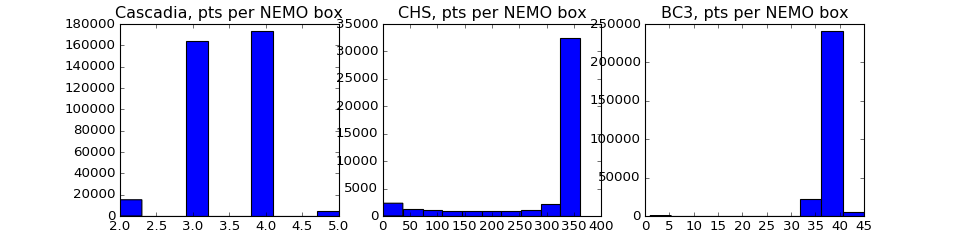

In [11]:
def dezero(x): return x.flatten()[x.flatten()>0]
plt.figure(figsize=(12,3)); plt.clf();
plt.subplot(1,3,1); plt.hist(dezero(cascount)); plt.title('Cascadia, pts per NEMO box')
plt.subplot(1,3,2); plt.hist(dezero(chscount)); plt.title('CHS, pts per NEMO box')
plt.subplot(1,3,3); plt.hist(dezero(bc3count)); plt.title('BC3, pts per NEMO box')

In [7]:
# Plotting helper funtions
def mm(x):
    return ma.masked_array(x, mask=(x == 0 | np.isnan(x)))
chsmask, casmask, b6mask, spmask = mm(chsmin), mm(casmin), mm(bathy6), mm(bathy6+bathyjpi)
def cmp(a,b,c,d,e):  # compare a and b, mask from c, colorbar limits d, title e
    im=plt.pcolormesh(c*0 + a -b); cb=plt.colorbar(im);
    im.set_cmap('seismic'); im.set_clim([-d,d]); cb.set_clim(-d,d); plt.title(e)

def shw(a,b,c,d):  # plot a, mask b, colorbar limits c, title d
    if b is None: b=mm(a)
    im=plt.pcolormesh(b*0+a); cb=plt.colorbar(im);
    im.set_cmap(cmocean.cm.haline); im.set_clim([0,c]); cb.set_clim(0,c); plt.title(d)

<IPython.core.display.Javascript object>


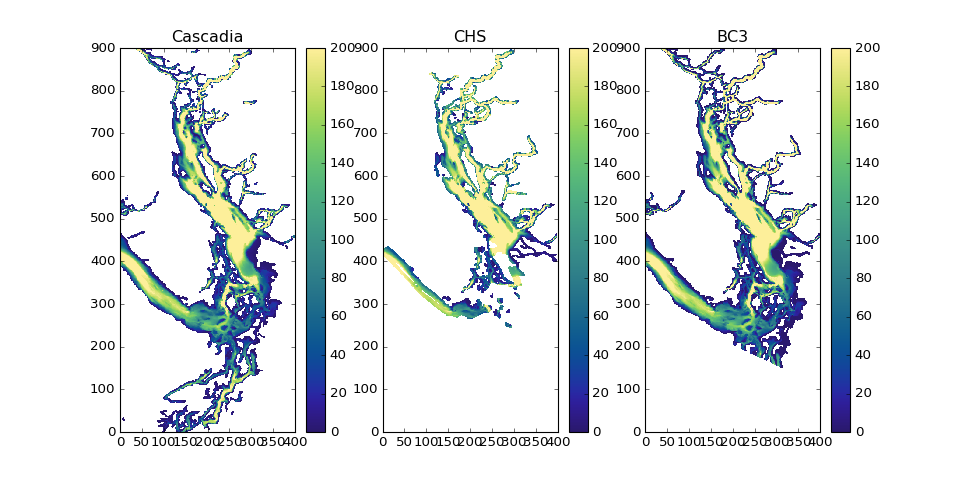

In [8]:
plt.figure(figsize=(12,6)); plt.clf();
plt.subplot(1,3,1); shw(casmean, None, 200, 'Cascadia')
plt.subplot(1,3,2); shw(chsmean, None, 200, 'CHS')
plt.subplot(1,3,3); shw(bc3mean, None, 200, 'BC3')

<IPython.core.display.Javascript object>


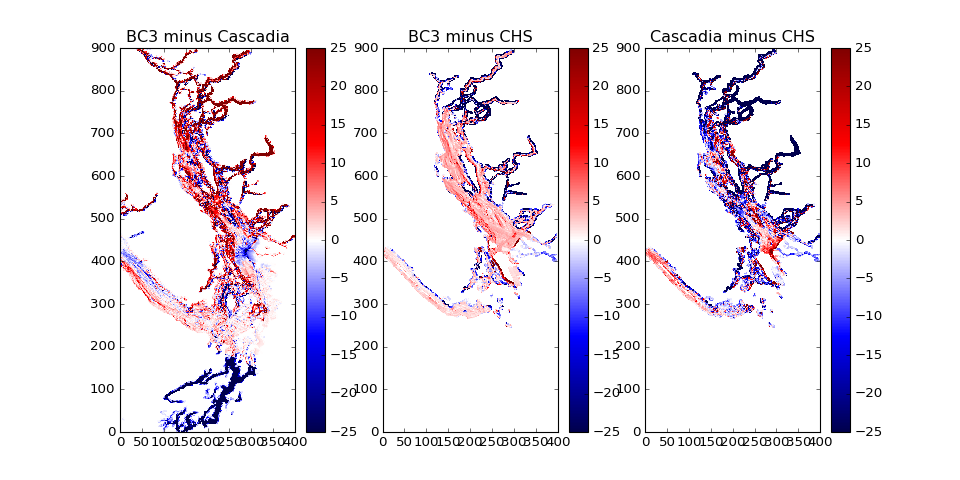

In [12]:
plt.figure(figsize=(12,6)); plt.clf();
plt.subplot(1,3,1); cmp(bc3mean, casmean, mm(casmean+bc3mean), 25, 'BC3 minus Cascadia')
plt.subplot(1,3,2); cmp(bc3mean, chsmean, mm(chsmean), 25, 'BC3 minus CHS')
plt.subplot(1,3,3); cmp(casmean, chsmean, mm(chsmean), 25, 'Cascadia minus CHS')

<IPython.core.display.Javascript object>


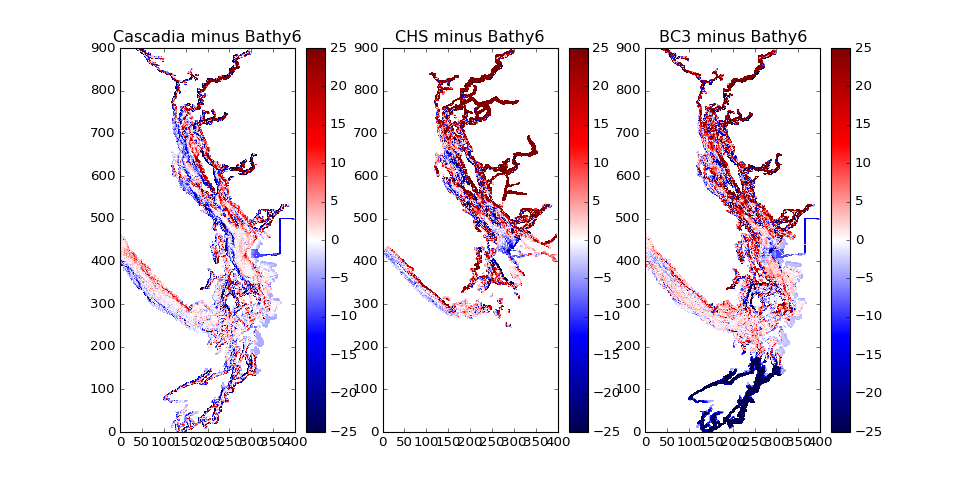

In [14]:
plt.figure(figsize=(12,6)); plt.clf();
plt.subplot(1,3,1); cmp(casmean, bathy6, mm(bathy6), 25, 'Cascadia minus Bathy6')
plt.subplot(1,3,2); cmp(chsmean, bathy6, mm(chsmean), 25, 'CHS minus Bathy6')
plt.subplot(1,3,3); cmp(bc3mean, bathy6, mm(bathy6), 25, 'BC3 minus Bathy6')